In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, kv, jvp

In [ ]:
lamb = 1064*1e-9
a = 4.5*1e-6 #fiber radius
n1 = 1.446 
n2 = 1.44
c = 3*1e8
R = 75*1e-9
P = 800*1e-3 #W
n_md = 1  # medium refractive index (??)
n_p = 1.46 # particle refractive index

In [45]:
l=0

NA = ((n1**2)-(n2**2))**(1/2)
V = (2*np.pi)*(a/lamb)*NA
k = 2*np.pi/lamb
w_0=0.65*a
m_rri = n_p/n_md

x_beta = np.linspace(0.001,V,10000)

/var/folders/d6/n5kkxz3125708zjn5q4h4bhh0000gn/T/ipykernel_19991/154617323.py:6: RuntimeWarning: invalid value encountered in divide
  return Y*(kv(v+1,Y)/kv(v,Y))


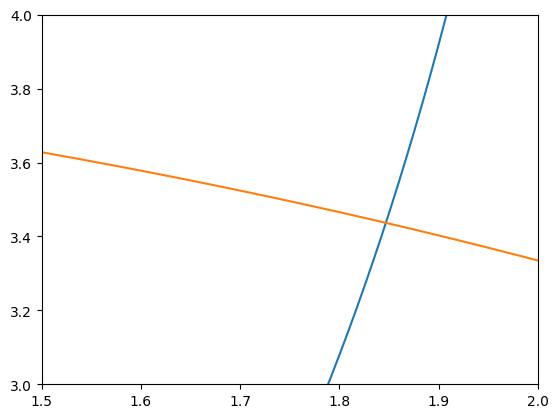

In [46]:
def LHS(v):
    return x_beta*(jv(v+1,x_beta)/(jv(v,x_beta)))

def RHS(v):
    Y = ((V**2)-(x_beta**2))**(1/2)
    return Y*(kv(v+1,Y)/kv(v,Y))

plt.plot(x_beta,LHS(l))
plt.plot(x_beta,RHS(l))
plt.ylim(3,4)
plt.xlim(1.5,2)
plt.show()

In [47]:
#2.1, 4.7
X_root = 1.845
beta_f = ((n1**2)*(k**2)-(X_root/a)**2)**(1/2)
kt = ((n1**2)*(k**2)-beta_f**2)**(1/2)
gamma_fiber = ((beta_f**2)-(n2**2)*(k**2))**(1/2)

In [48]:
x = np.linspace(-1e-4,1e-4,2000)
y = np.linspace(-1e-4,1e-4,2000)
z = np.linspace(-1e-4,1e-4,2000)

def calc_coefficients(v, kt, gamma_fiber, a):
    Jv_ka = jv(v, kt*a)
    Kv_ga = kv(v, gamma_fiber*a)

    A = 1.0
    B = A * Jv_ka / Kv_ga

    return A, B

def E_core(x,y,z,v):
    PHI = np.exp(-1j*v*np.arctan2(y,x))
    Z = np.exp(-1j*beta_f*z)
    A = calc_coefficients(l,kt,gamma_fiber,a)[0]
    R = A*jv(v,kt*(((x**2)+(y**2))**(1/2)))
    return PHI*Z*R

def E_cladding(x, y, z, v):
    PHI = np.exp(-1j * v * np.arctan2(y, x))
    Z = np.exp(-1j * beta_f * z)
    epsilon = 1e-15
    r = np.sqrt(x**2 + y**2) + epsilon  # evita zero exato
    B = calc_coefficients(l,kt,gamma_fiber,a)[1]
    R = B*kv(v, gamma_fiber * r)
    return PHI * Z * R

def E(x, y, z, v):
    r = np.sqrt(x**2 + y**2)
    return np.where(r < a, E_core(x, y, z, v), E_cladding(x, y, z, v))

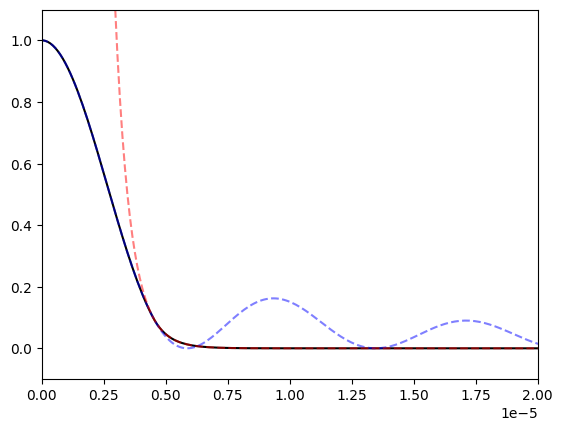

In [49]:
plt.plot(x,np.abs(E(x,0,0,l))**2, color='black')
plt.plot(x,np.abs(E_core(x,0,0,l))**2,'--',alpha=0.5,color='blue')
plt.plot(x,np.abs(E_cladding(x,0,0,l))**2,'--',alpha=0.5,color='red')

plt.ylim(-0.1,1.1)
plt.xlim(0,5*4*1e-6)
plt.show()

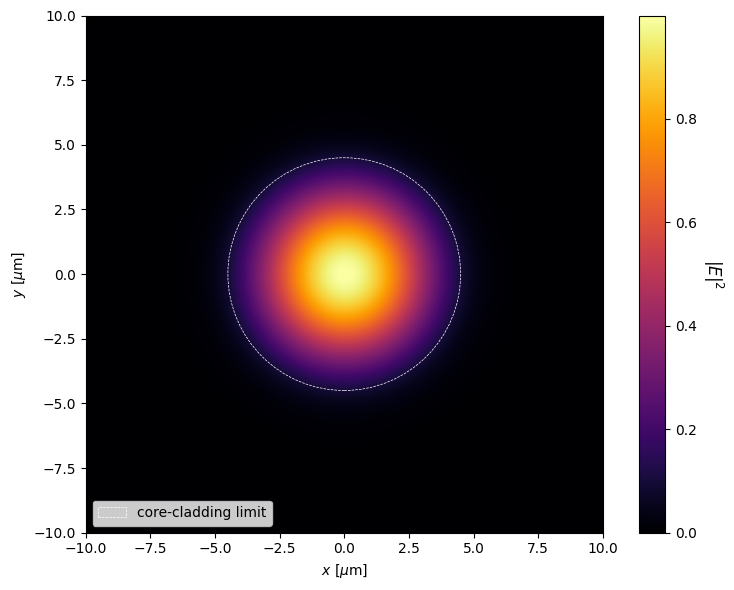

In [50]:
X, Y = np.meshgrid(x, y)
intensity = np.abs(E(X, Y, 0, l))**2

fig, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(intensity, extent=(x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6),
               origin='lower', cmap='inferno')

circle = plt.Circle((0, 0), a*1e6, color='white', fill=False, linestyle='--', linewidth=0.5,label='core-cladding limit')
ax.add_patch(circle)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_xlabel(r'$x\ \left[\mu\mathrm{m}\right]$')
ax.set_ylabel(r'$y\ \left[\mu\mathrm{m}\right]$')


cbar = plt.colorbar(im, ax=ax)
cbar.set_label(r'$|E|^2$', fontsize=12,rotation=270,labelpad=20)

plt.tight_layout()
plt.legend(loc='lower left')
plt.show()

For two counterpropagating beams, the forces are described as:

In [51]:
A=1

delta_omega=1e5

def F(x, y, z, t):
    r = np.sqrt(x**2 + y**2) + 1e-30

    alpha_fac = (2 * np.pi * n_md * (R**3) / c) * (((m_rri**2) - 1) / ((m_rri**2) + 2))
    F_0 = (P / (2 * np.pi * (w_0**2))) * alpha_fac

    cos_term = np.cos(np.remainder(2 * k * z - 2*np.pi-delta_omega*t,2*np.pi))
    sin_term = np.sin(np.remainder(2 * k * z - 2*np.pi-delta_omega*t,2*np.pi))

    fx =  F_0 * (2 * A**2 * jv(l, kt * r) * jvp(l, kt * r) * kt * x / r) * cos_term
    fy =  F_0 * (2 * A**2 * jv(l, kt * r) * jvp(l, kt * r) * kt * y / r) * cos_term
    fz = -F_0 * (2 * k * A**2 * jv(l, kt * r)**2) * sin_term

    return fx, fy, fz

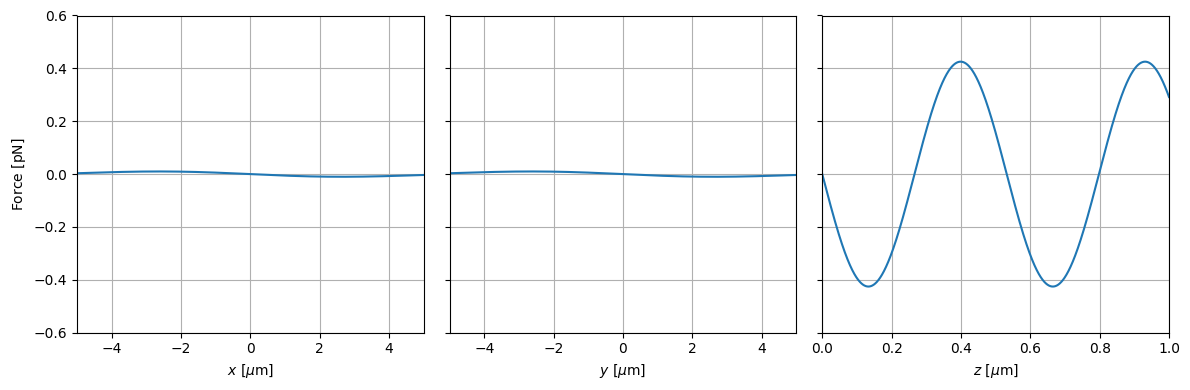

In [52]:
x_ax = np.linspace(-5e-6, 5e-6, 1_000_000)
y_ax = np.linspace(-5e-6, 5e-6, 1_000_000)
z_ax = np.linspace(-5e-6, 5e-6, 1_000_000)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].plot(x_ax * 1e6, F(x_ax, 0, 0, 0)[0] * 1e12)
axs[0].set_xlabel(r'$x\ \left[\mu\mathrm{m}\right]$')
axs[0].grid(True)
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-0.6,0.6)
axs[0].set_ylabel(r'Force $\left[\mathrm{pN}\right]$')

axs[1].plot(y_ax * 1e6, F(0, y_ax, 0, 0)[1] * 1e12)
axs[1].set_xlabel(r'$y\ \left[\mu\mathrm{m}\right]$')
axs[1].grid(True)
axs[1].set_xlim(-5, 5)

axs[2].plot(z_ax * 1e6, F(0, 0, z_ax, 0)[2] * 1e12)
axs[2].set_xlabel(r'$z\ \left[\mu\mathrm{m}\right]$')
axs[2].grid(True)
axs[2].set_xlim(0, 1)

plt.tight_layout()
plt.show()